<a href="https://colab.research.google.com/github/mwahaha-umich/ACLUFinalProject/blob/main/Anupriya_Dashboard_Spark2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Jupyter notebook is intended to assist with accessing plotly from outside of a Google Colab environment (Should technically work for any cloud environment that allows you to install NGROK). The problem with running plotly within Google Colab is that the ports that are opened by Plotly are not exposed to the outside world. In order to expose them we are going to create a network tunnel, that's where NGROK comes in.

A few things of note:
*  If you are using Google Drive for any information for this plot, you will want to copy that data "locally" before the graph will fuction externally. This is because we are starting up a new thread that will not carry over the Google Driver permissions you may have granted to the current thread.


# Download and install NGROK

First thing we need to do is download and install NGROK.

Important thing to note, if you ever get "OSError: [Errno 98] Address already in use" that means there is an instance of dash still running, the simplest solution is to restart the runtime.

In [87]:
# How to run a Dash app in Google Colab

## Requirements

### Install ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip


get_ipython().system_raw('./ngrok http 8050 &')

### Install Dash
!pip install dash  # The core dash backend
!pip install jupyter_dash
!pip install -U plotly
#Do not install any of these. When you install Dash, it includes these. If you call the install it installs a previous version of these and will generate an error.
#!pip install dash-html-components  # HTML components
#!pip install dash-core-components  # Supercharged components
#!pip install dash-table  # Interactive DataTable component (new!)

--2021-08-23 05:39:23--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.153.244.194, 52.55.225.227, 54.210.185.64, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.153.244.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.5’

ngrok-stable-linux- 100%[===================>]  13.19M  42.9MB/s    in 0.3s    

2021-08-23 05:39:23 (42.9 MB/s) - ‘ngrok-stable-linux-amd64.zip.5’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


Now that we have NGROK configured, we need a way to figure out what the URL will be to access NGROK. To do this we are going to have to execute some Linux commands to pull the established tunnels.

Additional Details:

Durring testing we discovered that occassionally the Curl command would come back with nothing. we suspect this is due to the async nature of the command pulling the list of tunnels before any of them have been established. So, we have built in a wait and a couple loops to ensure that we can get a proper URL.

Additionally, every time you restart the app you will need to generate a new tunnel. So make sure this method gets called before you execute your python file to start the server.

In [88]:
import os
import json
import time

LinuxOSList = ['posix']

def GetPublicIP(NumberOfLoops):
  #This code only works on a linux based OS, we'll skip running it if we're on an unknown OS
  if os.name in LinuxOSList:
    NumberOfLoops = NumberOfLoops + 1
    get_ipython().system_raw('./ngrok http 8050 &')
    time.sleep(1)
    result = os.popen("curl -s http://localhost:4040/api/tunnels").read()
    resultDict = json.loads(result)
    if 'tunnels' in resultDict.keys():
      publicIP = resultDict['tunnels'][0]['public_url']
      print(publicIP)
      return publicIP
    else:
      print("Number of Loops: " + NumberOfLoops)
      if NumberOfLoops > 5:
        return "Unable to get public IP"
      return GetPublicIP(NumberOfLoops)
  else:
    print(os.name)


In [89]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# Connect to Google Drive

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import requests

if 'google.colab' in str(get_ipython()):
  #We keep changing the different paths, so I'm going to check if various configurations exist.
  if (os.path.isdir("/content/drive/MyDrive/Shared with me/content/drive/My Drive/Shared with me/ACLU/")):
    GoogleDriveBase = "/content/drive/MyDrive/Shared with me/content/drive/My Drive/Shared with me/" #Anupriya
    WorkingDirectory = GoogleDriveBase + 'ACLU/' #Anupriya
  elif (os.path.isdir("/content/drive/MyDrive/Projects/ACLU")):
    GoogleDriveBase = "/content/drive/MyDrive/" #Mackenzie
    WorkingDirectory = GoogleDriveBase + "Projects/ACLU/" #Mackenzie
  else:  
    if (os.path.isdir("/content/drive/My Drive/Projects/ACLU/")):
      GoogleDriveBase = "/content/drive/My Drive/" #Kyle
      WorkingDirectory = GoogleDriveBase + "Projects/ACLU/" #Kyle
else: # We're not running in Google Colab, which means we're probably running locally. 
  #Put code here for local copies of the files
  GoogleDriveBase = "" 
  WorkingDirectory = GoogleDriveBase + "" 


WorkingFiles = WorkingDirectory + 'WorkingFiles/'
BasePickeDrive = GoogleDriveBase + WorkingDirectory + "Pickle/"
Dashboardfiles = WorkingDirectory + 'DashboardFiles/'

#Make the necessary folders for the script to run.
ListOfAllRequiredDirectories = [WorkingDirectory + 'Pickle', 
                          WorkingDirectory + 'WorkingFiles',
                          WorkingDirectory + 'AdditionalData',
                          WorkingDirectory + 'ACLUData']

for folder in ListOfAllRequiredDirectories:
  RunningPath = GoogleDriveBase + folder + "/"
  Path(RunningPath).mkdir(parents=True, exist_ok=True)

If you would like to run the previous example externally, just copy and paste your code into a new block like below. 

# Build and Test Dashboard Components

In [92]:
import altair as alt
import io
import dash
import dash_core_components as dcc
!pip install dash_bootstrap_components 
import dash_bootstrap_components as dbc
import dash_html_components as html
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
import plotly.express as px
import matplotlib.pyplot as plt
from vega_datasets import data
import folium
import pandas as pd
!pip install pywaffle
from pywaffle import Waffle

In [93]:
%%write_and_run Utility.py 

def FilterDataFrame(DataFrame, Race, Sex, AgeGroup, CountyName):
    dfFiltered = DataFrame[((DataFrame['RaceName'] == Race) | (Race == 'All') ) & 
                            ((DataFrame['Sex'] == Sex) | (Sex == 'All')) &
                            ((DataFrame['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                            ((DataFrame['CountyName'] == CountyName) | (CountyName == 'All'))]
    return dfFiltered


# Chart 1 - Election by Communication Type

In [94]:
%%write_and_run Chart1.py 

from Utility import *

def BuildChart1(dfFiltered):
  base = alt.Chart(dfFiltered).mark_bar().encode(
  x='count:Q',
  y = alt.Y('CommunicationType:N', title=None),
  color='CommunicationType:N',
  row='CampaignType:N').properties(title='Election by Communication Type')

  # Save html as a StringIO object in memory
  htmloutput = io.StringIO()
  base.save(htmloutput, 'html')

  chart1 = html.Iframe(
      height='500',
      width='1000',
      #sandbox='allow-scripts',

      # This is where we will pass the html
      srcDoc = htmloutput.getvalue(),

      # Get rid of the border box
      style={'border-width': '0px'}
  )
  return base, chart1

In [95]:
from Utility import *

from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=40000), to_values)
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')

Outreach = pd.read_csv(WorkingFiles + 'dfoutreachSumm.csv')
Outreach = Outreach.rename(columns={"ElectionType": "CampaignType"})
Outreach['CampaignType'] = Outreach['CampaignType'].replace({'lpv': 'voting rights', 
                                                           'scomi': 'Supreme Court',
                                                           'oakland': 'Oakland Prosecutor', 
                                                           'oakland prosecutor': 'Oakland Prosecutor', 
                                                           'oakland county prosecutor race': 'Oakland Prosecutor'})


Outreach['CountyName'] = Outreach['CountyName'].str.title()
print(Outreach.head())

Outreach.to_csv('mysite/dfoutreachSumm.csv')
BuildChart1(Outreach)[0]

    RaceName Sex AgeGroup  ... CommunicationType        CampaignType  count
0  Caucasian   F    45-64  ...              text       voting rights  32894
1  Caucasian   F      65+  ...              text  Oakland Prosecutor  78415
2      Asian   M    45-64  ...              mail       voting rights   1724
3      Asian   F    45-64  ...             phone  Oakland Prosecutor    834
4    Unknown   M    30-44  ...              text  Oakland Prosecutor    886

[5 rows x 7 columns]


/usr/local/lib/python3.7/dist-packages/altair/utils/data.py:229: AltairDeprecationWarning:

alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.



alt.Chart(...)

## Chart 2 (Biden)

In [96]:
biden_support_df = pd.read_csv(WorkingFiles + 'biden_support_df.csv')
biden_support_df['Voter File VANID'] = biden_support_df['count'].fillna(0)
biden_support_df = biden_support_df.rename(columns={"Voter File VANID": "# of Voters"})
biden_support_df["2020_Biden_Support"] = biden_support_df["2020_Biden_Support"].str.replace('\d+\.\s','')
biden_support_df.to_csv("biden_support_df_cleaned.csv")
biden_support_df.head()


,RaceName,Sex,AgeGroup,CountyName,2020_Biden_Support,count,# of Voters
0,Caucasian,M,45-64,Macomb,Lean Oppose,13,13
1,Asian,F,45-64,Macomb,Strong Oppose,8,8
2,Black,F,18-29,Genesee,Undecided/Unsure,211,211
3,Hispanic,F,30-44,Ottawa,Lean Support,7,7
4,Caucasian,M,18-29,Wayne,Undecided/Unsure,53,53


In [97]:
%%write_and_run BuildChartBiden.py 

from Utility import *

def BuildChartBiden(biden_support_filtered):
    chart2 = dcc.Graph(
      id='example-graph',
      figure=px.histogram(
          biden_support_filtered, 
          x="2020_Biden_Support", 
          y="count", 
          barmode='group', histfunc='sum',
          title="Biden 2020 Support", 
          labels={'2020_Biden_Support':''}),
      style={'width': '100vh', 'height': '50vh', 'float' : 'right','display': 'inline-block' }
    )
    return chart2


In [98]:
from Utility import *
dfBiden = pd.read_csv('biden_support_df_cleaned.csv')

app = JupyterDash(__name__)
app.layout =  html.Div([BuildChartBiden(dfBiden)])
#app.run_server(mode='inline') #We can only run 1 dashboard at a time so, we have to disable this if we want to run further charts

## Folium Map Data Prep

Chart 3 - Folium

In [99]:
dfOutreach = pd.read_csv(WorkingFiles + "dfOutreach.csv")
dfOutreach = dfOutreach[['Voter File VANID', 'ElectionType','CommunicationType', 'File']]
dfVoters = pd.read_csv(WorkingFiles + "dfVoters.csv")
dfVoters_sub = dfVoters[['Voter File VANID', 'FirstName', 'MiddleName',
       'LastName', 'DWID', 'mZip5', 'Age', 
       'MaritalStatus', 'Sex', 'mCity','mState', 'Suffix', 'CD', 'SD', 'HD', 'CountyName', 'DOB', 'DateReg',
       'EthnicCatalistName', 'Party', 'RaceName', 'Primary19', '2020_Biden_Support', 'Voting_Aug_Prim',
       'PoliceAccountability','VBM_Application', 'MarijuanaConviction','Absentee_Voting', 'Mass_Incarceration', 'AgeGroup']]

registered_voters = pd.read_csv(WorkingDirectory + 'AdditionalData/All Registered Voters Michigan.csv')
registered_voters.rename(columns = {'County':'CountyName'}, inplace = True)
county_pop_df = dfVoters_sub.groupby('CountyName').count()['Voter File VANID'].to_frame().reset_index()
county_pop_df['Voter File VANID'] = county_pop_df['Voter File VANID'].fillna(0)
county_pop_df['CountyName'] = county_pop_df['CountyName'].str.upper()


registered_voters.columns

total_voter_pop = pd.merge(county_pop_df, registered_voters, how = 'left', on = 'CountyName')
total_voter_pop['Voter File VANID'].astype(int)
print(total_voter_pop[pd.isna(total_voter_pop['All Registered Voters'])])

total_voter_pop['All Registered Voters'].astype(int)
total_voter_pop['fraction'] = total_voter_pop['Voter File VANID'] / total_voter_pop['All Registered Voters']
total_voter_pop['CountyName'] = total_voter_pop['CountyName'].str.title()
total_voter_pop['RaceName'] = 'All'
total_voter_pop['Sex'] = 'All'
total_voter_pop['AgeGroup'] = 'All'
total_voter_pop.head()



/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (8,10,22,30,34,41,43,47,48,52,53,54,55,56) have mixed types.Specify dtype option on import or set low_memory=False.



Empty DataFrame
Columns: [CountyName, Voter File VANID, Number, Feb Active Registered Voters, All Registered Voters, July Active Registered Voters, July All Registered Voters, October Active registered Voters, October All Registered Voters]
Index: []


,CountyName,Voter File VANID,Number,Feb Active Registered Voters,All Registered Voters,July Active Registered Voters,July All Registered Voters,October Active registered Voters,October All Registered Voters,fraction,RaceName,Sex,AgeGroup
0,Alcona,811,1,8229,9483,8281,9527,8671,9842,0.085521,All,All,All
1,Alger,706,2,6219,7424,6240,7413,6479,7565,0.095097,All,All,All
2,Allegan,14696,3,78749,88313,80078,89338,85091,93547,0.166408,All,All,All
3,Alpena,2829,4,20152,23991,20372,23950,21523,24768,0.117919,All,All,All
4,Antrim,2569,5,18734,21100,18901,21223,19836,21961,0.121754,All,All,All


In [100]:
from urllib.request import urlopen
import json
import numpy as np
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

data = {}
nest1 = counties["features"]
for thing in nest1: 
  if thing['properties']['STATE'] == '26':
    data[thing['id']] = thing['properties']['NAME']

In [101]:
trial = pd.DataFrame(data, index=[0])
mi_fips = trial.T.reset_index()
mi_fips = mi_fips.rename(columns={"index": "FIPS", 0: 'CountyName'})
mi_fips.head()

,FIPS,CountyName
0,26009,Antrim
1,26015,Barry
2,26023,Branch
3,26035,Clare
4,26037,Clinton


In [102]:
plotly_fips = pd.merge(total_voter_pop, mi_fips, how = 'left', on = 'CountyName')
plotly_fips = plotly_fips.replace(np.nan, 'nan', regex=True)
plotly_fips.to_csv("mysite/plotly_fips.csv")
plotly_fips.head()

,CountyName,Voter File VANID,Number,Feb Active Registered Voters,All Registered Voters,July Active Registered Voters,July All Registered Voters,October Active registered Voters,October All Registered Voters,fraction,RaceName,Sex,AgeGroup,FIPS
0,Alcona,811,1,8229,9483,8281,9527,8671,9842,0.085521,All,All,All,26001
1,Alger,706,2,6219,7424,6240,7413,6479,7565,0.095097,All,All,All,26003
2,Allegan,14696,3,78749,88313,80078,89338,85091,93547,0.166408,All,All,All,26005
3,Alpena,2829,4,20152,23991,20372,23950,21523,24768,0.117919,All,All,All,26007
4,Antrim,2569,5,18734,21100,18901,21223,19836,21961,0.121754,All,All,All,26009


In [103]:
%%write_and_run BuildFolium.py 

from Utility import *

def BuildFolium(total_voter_pop_filtered):

    #Add a folium map
    miMap = folium.Map(location=[44.3148, -85.6024], tiles='cartodbpositron', zoom_start=7)
    m = folium.Choropleth(geo_data=WorkingDirectory + 'AdditionalData/Counties_(v17a).geojson',
                 data=total_voter_pop_filtered, columns=['CountyName', 'fraction'], key_on='feature.properties.NAME',
                 fill_color='YlGnBu', fill_opacity=1).add_to(miMap)

    
    chart3 = html.Iframe(
        height='2000',
        width='1000',

        # This is where we will pass the html
        srcDoc = miMap._repr_html_(),

        # Get rid of the border box
        style={'border-width': '0px', 'float': 'right'}
    )
    return chart3, m

In [104]:
app = JupyterDash(__name__)
app.layout =  html.Div([BuildFolium(plotly_fips)[0]])
#app.run_server(mode='inline') #We can only run 1 dashboard at a time so, we have to disable this if we want to run further charts

# Chart 4-6 (Pie Charts) Mass Incarceration

In [105]:
%%write_and_run MassInc.py 
def BuildMassInc(mass_inc_filtered):
    chart4 = dcc.Graph(
      id='mass-inc-graph',
      figure=px.pie(
          mass_inc_filtered, 
          values="count",
          names="Mass_Incarceration", 
          title="Mass Incarceration", 
          labels={'Mass_Incarceration':'Support'}, 
          color='Mass_Incarceration',
          color_discrete_map={'Yes':'lightgreen',
                                 'No':'crimson',
                                 'Other/Unknown':'cyan'}),
      style={'width': '50vh', 'height': '50vh', 'float': 'right'}
    )
    return chart4

def BuildPolicing(policing_filtered):
    chart5 = dcc.Graph(
      id='policing-graph',
      figure=px.pie(
          policing_filtered, 
          values="count",
          names="PoliceAccountability", 
          title="Police Accountability", 
          labels={'PoliceAccountability':'Support'}, 
          color='PoliceAccountability',
          color_discrete_map={'Yes':'lightgreen',
                                 'No':'crimson',
                                 'Other/Unknown':'cyan',
                                 'Maybe':'goldenrod'}),
      style={'width': '50vh', 'height': '50vh', 'float': 'right'}
    )
    return chart5

def BuildMarijuana(weed_filtered):
    chart6 = dcc.Graph(
      id='weed-graph',
      figure=px.pie(
          weed_filtered, 
          values="count",
          names="MarijuanaConviction", 
          title="Marijuana Conviction", 
          labels={'Marijuana Conviction':'Support'}, 
          color='MarijuanaConviction',
          color_discrete_map={'Yes':'lightgreen',
                                 'No':'crimson',
                                 'Other/Unknown':'cyan'}),
      style={'width': '50vh', 'height': '50vh', 'float': 'right'}
    )
    return  chart6

In [106]:
mass_inc = pd.read_csv(WorkingFiles + "mass_inc.csv")
policing = pd.read_csv(WorkingFiles + "policing.csv")
weed = pd.read_csv(WorkingFiles + "weed.csv")

app = JupyterDash(__name__)
app.layout =  html.Div([BuildMassInc(mass_inc), BuildPolicing(policing), BuildMarijuana(weed)])
#app.run_server(mode='inline') #We can only run 1 dashboard at a time so, we have to disable this if we want to run further charts

# Chart 7

In [107]:
 %%write_and_run GenerateElectionLine.py
 def GenerateElectionLine(election_votes_filtered):
  chart7 = dcc.Graph(
    id='election-graph',
    figure=px.line(
        election_votes_filtered, 
        x='year', 
        y='count', 
        color = 'ElectionType'),
    style={'width': '200vh', 'height': '100vh', 'float': 'right', 'display': 'inline-block'}
  )
  return chart7

In [108]:
election_votes = pd.read_csv(WorkingFiles + "election_votes.csv")
election_votes = election_votes.replace(np.nan, 'nan', regex=True)
app = JupyterDash(__name__)
app.layout =  html.Div([GenerateElectionLine(election_votes)])
#app.run_server(mode='inline') #We can only run 1 dashboard at a time so, we have to disable this if we want to run further charts

# Unknown

In [109]:
df_aggregate = pd.read_csv(WorkingFiles + "dfoutreach.csv")

df_aggregate = df_aggregate.rename(columns={"Voter File VANID": "Count", 'ElectionType': 'CampaignType'})
print(df_aggregate.columns)
df_aggregate['CampaignType'] = df_aggregate['CampaignType'].replace({'lpv': 'Statewide voting rights/voter education race', 
                                                           'scomi': 'Supreme Court of Michigan Race',
                                                           'oakland': 'Oakland County Prosecutor Race', 
                                                           'oakland prosecutor': 'Oakland County Prosecutor Race', 
                                                           'oakland county prosecutor race': 'Oakland County Prosecutor Race'})

df_aggregate = df_aggregate.replace(np.nan, 'nan', regex=True)
df_aggregate = df_aggregate.replace(np.nan, 'nan', regex=True)


Index(['RaceName', 'Sex', 'AgeGroup', 'CountyName', 'CommunicationType',
       'CampaignType', 'count'],
      dtype='object')


## Waffle Graphs

In [110]:
df_aggregate = pd.read_csv(WorkingFiles + "dfoutreach.csv")
df_aggregate.head()

,RaceName,Sex,AgeGroup,CountyName,CommunicationType,ElectionType,count


In [111]:
old_outreach = pd.read_csv(WorkingFiles + 'dfOutreach.csv')
dfVoters_dem_only = dfVoters_sub[['RaceName', 'Sex', 'AgeGroup', 'CountyName','Voter File VANID']]
new_outreach = pd.merge(old_outreach, dfVoters_dem_only, how = 'left', on='Voter File VANID')
new_outreach = new_outreach[['RaceName', 'Sex', 'AgeGroup', 'CountyName', 'CommunicationType',
                             'ElectionType', 'Voter File VANID']]
new_outreach = new_outreach.groupby(['RaceName', 'Sex', 'AgeGroup', 'CountyName', 'CommunicationType',
                             'ElectionType']).count().reset_index()
new_outreach = new_outreach.rename(columns={"Voter File VANID": "Count", "ElectionType": "CampaignType"})
new_outreach = new_outreach[(new_outreach['CampaignType'] == 'lpv') | (new_outreach['CampaignType'] == 'scomi') | (new_outreach['CampaignType'] == 'oakland')]
new_outreach.to_csv(WorkingFiles + "outreach_cleaned.csv")
new_outreach.head()


,RaceName,Sex,AgeGroup,CountyName,CommunicationType,CampaignType,Count
0,Asian,F,18-29,Allegan,call,lpv,3
1,Asian,F,18-29,Allegan,text,lpv,6
2,Asian,F,18-29,Alpena,text,lpv,1
3,Asian,F,18-29,Bay,call,lpv,13
4,Asian,F,18-29,Bay,mail,lpv,6


In [112]:
def GenerateWaffleGraph():
  ocp_mail = dcc.Graph(
    id='ocp-mail',
    figure=plt.figure(FigureClass=Waffle, 
                      rows=10,
                      values={'Voted Both': 15, 'Voted August20': 25, 'Voted November20': 20, "Didn't Vote": 40}, 
                      colors=("#a7d7b5", "#fcaa17", "#a3dbe3", "#fabeaf"),
                      title={'label': 'OCP Vote % Amongst Those Contacted By Mail', 'loc': 'left'},
                      #labels=["{0} ({1}%)".format(k, v) for k, v in values.items()],
                      legend={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}),
    style={'width': '50vh', 'height': '50vh', 'float': 'right'}
  )
  return ocp_mail

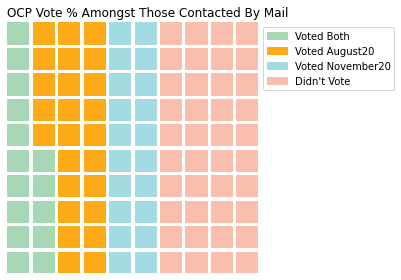

In [113]:
mass_inc = pd.read_csv(WorkingFiles + "mass_inc.csv")

app = JupyterDash(__name__)
app.layout =  html.Div([GenerateWaffleGraph()])

# Chart 8

In [114]:
def GenerateCommGraph(new_outreach):
    comm_graph = dcc.Graph(
      id='comm-graph',
      figure=px.histogram(new_outreach, x="CommunicationType", y="Count", color="CommunicationType", 
                          barmode="group", histfunc='sum', facet_col="CampaignType", facet_col_spacing=0.05, 
                          title="Campaign by Communication Type").for_each_annotation(lambda a: a.update(text=a.text.split("=")[1])),
      style={'width': '150vh', 'height': '50vh', 'float': 'right'}
    )


In [115]:

app = JupyterDash(__name__)
app.layout =  html.Div([GenerateCommGraph(new_outreach)])
app.run_server(mode='inline') #We can only run 1 dashboard at a time so, we have to disable this if we want to run further charts

<IPython.core.display.Javascript object>

## Participation General 20 Graph

In [116]:
gen20_participation = pd.read_csv(WorkingFiles + "gen20_participation.csv")
gen20_participation['CountyName'] = gen20_participation['CountyName'].str.title()
gen20_participation.to_csv(WorkingFiles + "gen20_participation.csv")
gen20_participation.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,RaceName,AgeGroup,CountyName,Sex,participation,count
0,0,0,0,0,0,0,Black,30-44,Washtenaw,F,A,5769
1,1,1,1,1,1,1,Asian,45-64,Ingham,M,A,567
2,2,2,2,2,2,2,Caucasian,30-44,Lapeer,M,P,2463
3,3,3,3,3,3,3,Hispanic,18-29,Eaton,M,P,146
4,4,4,4,4,4,4,Caucasian,65+,Jackson,F,P,357


In [117]:
def Gen20participation(gen20_participation):
  gen20 = dcc.Graph(
      id = 'gen20participation-graph', 
      figure = px.histogram(gen20_participation, x="CountyName", y='count', 
                            color='participation', barmode='stack', 
                            histfunc='sum', title='General 20 Participation').update_xaxes(categoryorder = 'total descending'), 
      style={'width': '150vh', 'height': '50vh', 'float': 'right'}
  )
  return gen20

In [118]:
app = JupyterDash(__name__)
app.layout =  html.Div([Gen20participation(gen20_participation)])

## Copy Files and Prepare Dashboard Run

In [119]:
import shutil
import os
if not os.path.exists('mysite'):
    os.makedirs('mysite')
#Copy Datafiles to Server
shutil.copyfile(WorkingFiles + "election_votes.csv","mysite/election_votes.csv")
shutil.copyfile(WorkingFiles + "dfoutreach.csv","mysite/dfoutreach.csv")
shutil.copyfile(WorkingFiles + "total_voter_pop.csv","mysite/total_voter_pop.csv")
shutil.copyfile(WorkingFiles + "biden_support_df.csv","mysite/biden_support_df.csv")
shutil.copyfile(WorkingFiles + "mass_inc.csv","mysite/mass_inc.csv")
shutil.copyfile(WorkingFiles + "policing.csv","mysite/policing.csv")
shutil.copyfile(WorkingFiles + "weed.csv","mysite/weed.csv")
shutil.copyfile(WorkingFiles + "outreach_cleaned.csv", "mysite/outreach_cleaned.csv")
shutil.copyfile(WorkingFiles + "gen20_participation.csv", "mysite/gen20_participation.csv")
shutil.copyfile(WorkingDirectory + 'AdditionalData/Counties_(v17a).geojson', "mysite/Counties_(v17a).geojson")



#"mysite/plotly_fips.csv", 'dfoutreachSumm.csv' and "mysite/dfVoters_sub.csv" were Copied earlier in this notebook


'mysite/Counties_(v17a).geojson'

Finding all the distinct values for our dropdown takes a bit so we will pre-process that and add it to a pickle.

In [120]:
import pickle
FilterColumns = {}
FilterColumnNames = ["RaceName", "Sex", "AgeGroup", "CountyName"]

for column in FilterColumnNames:
  FilterColumns[column] = list(dfVoters_sub[column].astype("str").replace(np.nan, 'nan', regex=True).unique())
  FilterColumns[column].append("All")
  print(FilterColumns[column])

with open('mysite/FilterColumns.pickle', 'wb') as f:
    pickle.dump(FilterColumns, f)

['Caucasian', 'Black', 'Unknown', 'Hispanic', 'Asian', 'Native American', 'All']
['F', 'M', 'U', 'All']
['65+', '45-64', '18-29', '30-44', 'nan', 'All']
['Wayne', 'Macomb', 'Oakland', 'Genesee', 'Washtenaw', 'Crawford', 'Berrien', 'Benzie', 'Jackson', 'Presque Isle', 'Marquette', 'Houghton', 'Ingham', 'Kent', 'Oscoda', 'Saginaw', 'Bay', 'Isabella', 'Lapeer', 'Clare', 'Eaton', 'Mason', 'Menominee', 'Dickinson', 'Clinton', 'Calhoun', 'St. Clair', 'Iosco', 'Ottawa', 'Chippewa', 'Monroe', 'Iron', 'Arenac', 'Wexford', 'Emmet', 'Gladwin', 'Allegan', 'Kalamazoo', 'Missaukee', 'Otsego', 'Mackinac', 'Delta', 'Hillsdale', 'Newaygo', 'Livingston', 'Branch', 'Lenawee', 'Osceola', 'Cheboygan', 'Sanilac', 'Roscommon', 'Van Buren', 'Shiawassee', 'Schoolcraft', 'Tuscola', 'Montcalm', 'Grand Traverse', 'Muskegon', 'Ogemaw', 'Leelanau', 'Alcona', 'St. Joseph', 'Midland', 'Mecosta', 'Charlevoix', 'Manistee', 'Huron', 'Cass', 'Alpena', 'Barry', 'Ionia', 'Gratiot', 'Montmorency', 'Antrim', 'Oceana', 'Gogeb

# Build our Dashboard

Now for the final few bits before we can run this properly

In [121]:
!pip install dash_bootstrap_components

In [128]:
%%write_and_run AltairGraph.py

import altair as alt
import io
import dash
import dash_core_components as dcc
import dash_bootstrap_components as dbc
import dash_html_components as html
import plotly.graph_objs as go
from jupyter_dash import JupyterDash
import plotly.express as px
import matplotlib.pyplot as plt
from vega_datasets import data
import folium
import pandas as pd
import numpy as np
from pywaffle import Waffle
from io import BytesIO
import base64
import pickle

from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=40000), to_values)
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')

from urllib.request import urlopen
import json
import numpy as np
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

with open('mysite/FilterColumns.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    FilterColumns = pickle.load(f)

total_voter_pop = pd.read_csv("mysite/total_voter_pop.csv")
total_voter_pop = total_voter_pop.replace(np.nan, 'nan', regex=True)

biden_support_df = pd.read_csv("mysite/biden_support_df.csv")
biden_support_df = biden_support_df.replace(np.nan, 'nan', regex=True)

mass_inc = pd.read_csv("mysite/mass_inc.csv")
mass_inc = mass_inc.replace(np.nan, 'nan', regex=True)

policing = pd.read_csv("mysite/policing.csv")
policing = policing.replace(np.nan, 'nan', regex=True)

weed = pd.read_csv("mysite/weed.csv")
weed = weed.replace(np.nan, 'nan', regex=True)

election_votes = pd.read_csv("mysite/election_votes.csv")
election_votes = election_votes.replace(np.nan, 'nan', regex=True)

plotly_fips = pd.read_csv("mysite/plotly_fips.csv")
plotly_fips = plotly_fips.replace(np.nan, 'nan', regex=True)

new_outreach = pd.read_csv("mysite/outreach_cleaned.csv")

df_aggregate = pd.read_csv("mysite/dfoutreach.csv")
Outreach = pd.read_csv("mysite/dfoutreachSumm.csv")


new_outreach = new_outreach.replace(np.nan, 'nan', regex=True)

df_aggregate = df_aggregate.rename(columns={"Voter File VANID": "Count", 'ElectionType': 'CampaignType'})
print(df_aggregate.columns)
df_aggregate['CampaignType'] = df_aggregate['CampaignType'].replace({'lpv': 'Statewide voting rights/voter education race', 
                                                           'scomi': 'Supreme Court of Michigan Race',
                                                           'oakland': 'Oakland County Prosecutor Race', 
                                                           'oakland prosecutor': 'Oakland County Prosecutor Race', 
                                                           'oakland county prosecutor race': 'Oakland County Prosecutor Race'})

df_aggregate = df_aggregate.replace(np.nan, 'nan', regex=True)
df_aggregate = df_aggregate.replace(np.nan, 'nan', regex=True)

gen20_participation = pd.read_csv("mysite/gen20_participation.csv")
gen20_participation = gen20_participation.replace(np.nan, 'nan', regex=True)
#alt.data_transformers.disable_max_rows()

# Don't need this with the cars dataset
alt.data_transformers.enable('default', max_rows=150000)

cars = data.cars()

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets)
app.css.append_css({'external_url':
                    'https://cdn.rawgit.com/gschivley/8040fc3c7e11d2a4e7f0589ffc829a02/raw/fe763af6be3fc79eca341b04cd641124de6f6f0d/dash.css'
                    })
app.title = 'Test dash and altair'
server = app.server


FilterColumnNames = ["RaceName", "Sex", "AgeGroup", "CountyName"]


#Build our dropdowns for each of the Filter Columns
DropDowns = []
inputs = []
for ColumnName in FilterColumnNames:
    DropDowns.append(
        html.Div([
            html.Label(ColumnName),
            dcc.Dropdown(
                id=ColumnName,
                options=[{'label': i, 'value':i} for i in FilterColumns[ColumnName]],
                value='All'
            )
        ],
        style={'width': '250px', 'marginRight': 'auto',
              'marginLeft': 'auto', 'textAlign': 'center'},
        className='column'))
    inputs.append(dash.dependencies.Input(ColumnName, 'value'))

#Build our main layout
#app.layout = html.Div(children=[html.Div(children=DropDowns, className='row'), html.Pre(id='plot', children="If this doesn't go away you have an error")])
app.layout = html.Div(children=[dbc.Row(children=DropDowns, className="col-1 col-sm-1 col-lg-2 col-xl-4"), html.Div(id="plot")])
@app.callback(
    dash.dependencies.Output('plot', 'children'),
    inputs
)
def pick_figure(Race, Sex, AgeGroup, CountyName):
    #This is our key. Filter everything before passing it into the charts.
    dfFiltered = Outreach[((Outreach['RaceName'] == Race) | (Race == 'All') ) & 
                              ((Outreach['Sex'] == Sex) | (Sex == 'All')) &
                              ((Outreach['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((Outreach['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    total_voter_pop_filtered = total_voter_pop[((total_voter_pop['RaceName'] == Race) | (Race == 'All') ) & 
                              ((total_voter_pop['Sex'] == Sex) | (Sex == 'All')) &
                              ((total_voter_pop['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((total_voter_pop['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    biden_support_filtered = biden_support_df[((biden_support_df['RaceName'] == Race) | (Race == 'All') ) & 
                              ((biden_support_df['Sex'] == Sex) | (Sex == 'All')) &
                              ((biden_support_df['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((biden_support_df['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    mass_inc_filtered = mass_inc[((mass_inc['RaceName'] == Race) | (Race == 'All') ) & 
                              ((mass_inc['Sex'] == Sex) | (Sex == 'All')) &
                              ((mass_inc['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((mass_inc['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    policing_filtered = policing[((policing['RaceName'] == Race) | (Race == 'All') ) & 
                              ((policing['Sex'] == Sex) | (Sex == 'All')) &
                              ((policing['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((policing['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    weed_filtered = weed[((weed['RaceName'] == Race) | (Race == 'All') ) & 
                              ((weed['Sex'] == Sex) | (Sex == 'All')) &
                              ((weed['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((weed['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    election_votes_filtered = election_votes[((election_votes['RaceName'] == Race) | (Race == 'All') ) & 
                              ((election_votes['Sex'] == Sex) | (Sex == 'All')) &
                              ((election_votes['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((election_votes['CountyName'] == CountyName) | (CountyName == 'All'))]
    election_votes_filtered = election_votes_filtered.groupby(['year', 'ElectionType']).sum().reset_index()

    plotly_fips_filtered = plotly_fips[((plotly_fips['CountyName'] == CountyName) | (CountyName == 'All'))]
    
    gen20_participation_filtered = gen20_participation[((gen20_participation['RaceName'] == Race) | (Race == 'All') ) & 
                              ((gen20_participation['Sex'] == Sex) | (Sex == 'All')) &
                              ((gen20_participation['AgeGroup'] == AgeGroup) | (AgeGroup == 'All')) &
                              ((gen20_participation['CountyName'] == CountyName) | (CountyName == 'All'))]
   
    #We should also aggregate it. This will keep our record count low and avoid errors. We will obviously need to add columns that we need.
    #dfFiltered = dfFiltered.groupby(by=['2020_Biden_Support', 'CountyName']).sum()
    #dfFiltered = dfFiltered.reset_index()

    #Encode the Altair Chart
    base = alt.Chart(dfFiltered).mark_bar().encode(
    x='Count:Q',
    y = alt.Y('CommunicationType:N', title=None),
    color='CommunicationType:N',
    row='ElectionType:N').properties(title='Election by Communication Type')

    # Save html as a StringIO object in memory
    htmloutput = io.StringIO()
    base.save(htmloutput, 'html')

    chart1 = html.Iframe(
        height='500',
        width='1000',
        #sandbox='allow-scripts',

        # This is where we will pass the html
        srcDoc = htmloutput.getvalue(),

        # Get rid of the border box
        style={'border-width': '0px'}
    )

    #Create a simple Plotly Express chart

    chart2 = dcc.Graph(
      id='example-graph',
      figure=px.histogram(
          biden_support_filtered, 
          x="2020_Biden_Support", 
          y="count", 
          barmode='group', histfunc='sum',
          title="Biden 2020 Support", 
          labels={'2020_Biden_Support':''}),
          style={'width': '70vh', 'height': '90vh', 'float': 'right'}
    )

    #Add a folium map
    #start_coords = (44.3148, -85.6024)
    #folium_map = folium.Map(location=start_coords, tiles='cartodbpositron', zoom_start=6)
    miMap = folium.Map(location=[44.3148, -85.6024], tiles='cartodbpositron', zoom_start=7)
    m = folium.Choropleth(geo_data='mysite/Counties_(v17a).geojson',
                 data=total_voter_pop_filtered, columns=['CountyName', 'fraction'], key_on='feature.properties.NAME',
                 fill_color='YlGnBu', fill_opacity=1).add_to(miMap)

    
    chart3 = html.Iframe(
        height='2000',
        width='1000',

        # This is where we will pass the html
        srcDoc = miMap._repr_html_(),

        # Get rid of the border box
        style={'border-width': '0px', 'float': 'right'}
    )
    
    chart4 = dcc.Graph(
      id='mass-inc-graph',
      figure=px.pie(
          mass_inc_filtered,
          values="count",
          hole=0.5,
          names="Mass_Incarceration",
          title="Support for Ending Mass Incarceration",
          labels={'Mass_Incarceration':'Support'},
          color='Mass_Incarceration',
          color_discrete_map={'Yes':'#A7D7B5',
                                 'No':'#FCAA17',
                                 'Other/Unknown':'#A3DBE3'}),
      style={'width': '60vh', 'height': '50vh', 'float': 'right'}
    )
    
    chart5 = dcc.Graph(
      id='policing-graph',
      figure=px.pie(
          policing_filtered, 
          values="count",
          hole=0.5,
          names="PoliceAccountability", 
          title="Support for Police Accountability", 
          labels={'PoliceAccountability':'Support'}, 
          color='PoliceAccountability',
          color_discrete_map={'Yes':'#a7d7b5',
                                 'No':'#fcaa17',
                                 'Other/Unknown':'#a3dbe3',
                                 'Maybe':'#fabeaf'}),
      style={'width': '60vh', 'height': '50vh', 'float': 'right'}
    )

    chart6 = dcc.Graph(
      id='weed-graph',
      figure=px.pie(
          weed_filtered, 
          values="count",
          hole=0.5,
          names="MarijuanaConviction", 
          title="Support for Marijuana Legalization", 
          labels={'Marijuana Conviction':'Support'}, 
          color='MarijuanaConviction',
          color_discrete_map={'Yes':'#a7d7b5',
                                 'No':'#fcaa17',
                                 'Other/Unknown':'#a3dbe3'}),
      style={'width': '60vh', 'height': '50vh', 'float': 'right'}
    )

    chart7 = dcc.Graph(
      id='election-graph',
      figure=px.line(
          election_votes_filtered, 
          x='year', 
          y='count', 
          color = 'ElectionType', title = 'Election Voters over Time'),
      style={'width': '200vh', 'height': '100vh', 'float': 'right', 'display': 'inline-block'}
    )

    plotly_map = dcc.Graph(
      id='map-graph',
      figure=px.choropleth(plotly_fips_filtered, geojson=counties, locations='FIPS', color='fraction',
                           color_continuous_scale="Viridis_r",
                           range_color=(0, 0.3),
                           scope="usa",
                           labels={'fraction':'ACLU Voters by Registered Voters'}, 
                    hover_data=["CountyName", 'fraction', 'Voter File VANID', 'All Registered Voters']
                          ).update_geos(fitbounds="locations", visible=False).update_layout(margin={"r":0,"t":0,"l":0,"b":0}),
      style={'width': '200vh', 'height': '100vh', 'float': 'right'}
    )

    comm_graph = dcc.Graph(
      id='comm-graph',
      figure=px.histogram(dfFiltered, x="CampaignType", y="count", color="CommunicationType", 
                          color_discrete_map={'text':'#a7d7b5','mail':'#ffe06a','phone':'#fcaa17','call':'#a3dbe3','postcards':'#fabeaf'},
                          barmode="group", histfunc='sum', 
                          title="Campaign by Communication Type"),
      style={'width': '125vh', 'height': '100vh', 'float': 'right'}
    )
    
    gen20 = dcc.Graph(
      id = 'gen20participation-graph', 
      figure = px.histogram(gen20_participation_filtered, x="CountyName", y='count', 
                            color='participation', barmode='stack', 
                            histfunc='sum', title='General 20 Participation').update_xaxes(categoryorder = 'total descending'), 
      style={'width': '200vh', 'height': '100vh', 'float': 'right'}
      )
    #return plotly_map, comm_graph, chart4, chart2, chart5, chart6, ocp_mail
    Title = dbc.Row(dbc.Col(html.H1("ACLU Voter Info"), width=12))
    Map = dbc.Row(dbc.Col(plotly_map, width=12))
    MapLabelRow = dbc.Row(dbc.Col(html.H3('Note: Map includes data that does not contain Sex, Age or Race data and will not filter on those drop-downs.')))
    PieChartRow = dbc.Row([dbc.Col(chart4), dbc.Col(chart5), dbc.Col(chart6)], className="col-sm-1 col-lg-2 col-xl-4")
    CommBidenRow = dbc.Row([dbc.Col(comm_graph), dbc.Col(chart2)])
    Gen20Row = dbc.Row(dbc.Col(gen20))
    VotesLine = dbc.Row(dbc.Col(chart7))  
    VotesByTypeLine = dbc.Row(dbc.Col(chart1))
    #return Map , MapLabelRow, comm_graph, chart2, PieChartRow, chart7
    return Title, Map, MapLabelRow, PieChartRow, CommBidenRow, Gen20Row, VotesLine

if __name__ == '__main__':
    app.run_server(debug=True)

app.run_server(mode="inline")

application = app.server #This line is needed for PythonAnywhere deployment

Index(['RaceName', 'Sex', 'AgeGroup', 'CountyName', 'CommunicationType',
       'CampaignType', 'count'],
      dtype='object')
Dash app running on:


/usr/local/lib/python3.7/dist-packages/dash/resources.py:72: UserWarning:

You have set your config to `serve_locally=True` but A local version of https://cdn.rawgit.com/gschivley/8040fc3c7e11d2a4e7f0589ffc829a02/raw/fe763af6be3fc79eca341b04cd641124de6f6f0d/dash.css is not available.
If you added this file with `app.scripts.append_script` or `app.css.append_css`, use `external_scripts` or `external_stylesheets` instead.
See https://dash.plot.com/external-resources



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

This section produces a public URL that can be shared. It's useful durring development, however it should be note that NGROK is rate limited and if you change the drop-downs multiple times in a minute you will get an error message. The solution is simply to wait a little bit for the rate to reset.

In [123]:
publicIP = GetPublicIP(0)
### Run Dash app
!python AltairGraph.py

/usr/local/lib/python3.7/dist-packages/dash/resources.py:72: UserWarning:

You have set your config to `serve_locally=True` but A local version of https://cdn.rawgit.com/gschivley/8040fc3c7e11d2a4e7f0589ffc829a02/raw/fe763af6be3fc79eca341b04cd641124de6f6f0d/dash.css is not available.
If you added this file with `app.scripts.append_script` or `app.css.append_css`, use `external_scripts` or `external_stylesheets` instead.
See https://dash.plot.com/external-resources



http://82a4-35-237-88-105.ngrok.io
Index(['RaceName', 'Sex', 'AgeGroup', 'CountyName', 'CommunicationType',
       'CampaignType', 'count'],
      dtype='object')
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "AltairGraph" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
Traceback (most recent call last):
  File "AltairGraph.py", line 329, in <module>
    app.run_server(debug=True)
  File "/usr/local/lib/python3.7/dist-packages/jupyter_dash/jupyter_app.py", line 180, in run_server
    super_run_server(**kwargs)
  File "/usr/local/lib/python3.7/dist-packages/dash/dash.py", line 1750, in run_server
    self.server.run(host=host, port=port, debug=debug, **flask_run_options)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 990, in run
    run_simple(host, port, self, **options)
  File "/usr/local/lib/python3.7/dist-packages/werkzeug/serving.py", line 1030, in run_simple
    s.bind(server_address)
OSErro

# Prep for public dashboard

Now that we have our working dashboard and all the files pre-aggregated and transformed specifically for our dashboard we need to copy everything out to a staging directory.

In [124]:
for f in os.listdir(Dashboardfiles):
    os.remove(os.path.join(Dashboardfiles, f))

shutil.copyfile("mysite/election_votes.csv", Dashboardfiles + "election_votes.csv")
shutil.copyfile("mysite/dfoutreach.csv", Dashboardfiles + "dfoutreach.csv")
shutil.copyfile("mysite/total_voter_pop.csv", Dashboardfiles + "total_voter_pop.csv")
shutil.copyfile("mysite/biden_support_df.csv", Dashboardfiles + "biden_support_df.csv")
shutil.copyfile("mysite/mass_inc.csv", Dashboardfiles + "mass_inc.csv")
shutil.copyfile("mysite/policing.csv", Dashboardfiles + "policing.csv")
shutil.copyfile("mysite/weed.csv", Dashboardfiles + "weed.csv")
shutil.copyfile("mysite/outreach_cleaned.csv", Dashboardfiles + "outreach_cleaned.csv")
shutil.copyfile("mysite/gen20_participation.csv", Dashboardfiles + "gen20_participation.csv")
shutil.copyfile("mysite/Counties_(v17a).geojson", Dashboardfiles + "Counties_(v17a).geojson")
shutil.copyfile('mysite/FilterColumns.pickle', Dashboardfiles +  "FilterColumns.pickle")
shutil.copyfile("mysite/dfoutreachSumm.csv", Dashboardfiles +  "dfoutreachSumm.csv")

shutil.copyfile("AltairGraph.py", Dashboardfiles + "AltairGraph.py")


'/content/drive/MyDrive/Projects/ACLU/DashboardFiles/AltairGraph.py'

In [125]:
! pip freeze > spark_dashboard_requirements.txt